In [227]:
from fashion_mnist.utils.mnist_reader import load_mnist
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import time

In [4]:
X_train, y_train = load_mnist('fashion_mnist/data/fashion', kind='train')
X_test, y_test = load_mnist('fashion_mnist/data/fashion', kind='t10k')

# Exploración del dataset fashion Mnist

Visualmente, una observacion del dataset representa a una imagen perteneciente a una de las 10 clases de ropa que contiene el mismo.
### Clases de ropa

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

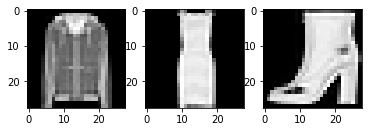

In [47]:
fig, axes = plt.subplots(1,3)
s = 28
for i in range(len(axes)):
    #print(ax)
    tmpX = np.array(X_train[s])
    tmpX = tmpX.reshape(28,28)  # ya que las observaciones estan flattened
    axes[i].imshow(tmpX, interpolation='nearest', cmap='gray')
    s+=30
#ax[1].imshow(X, interpolation='nearest', cmap='gray')
plt.show()

Cada imagen consiste en 784 (28*28) features, en donde cada una de estas pertenece al dominio de [0-255], siendo este la intensidad de brillo para cada pixel. 0 representa el color negro, y conforme se acerque a 255, más brillante será el pixel (más blanco)

In [53]:
# una sola observacion del dataset, tiene 784 features que corresponden a los pixeles de la imagen.
X_train[28].shape

(784,)

In [56]:
y_train[28] # la observacion numero 28, corresponde a la clase 4, es decir, a la clase de chaqueta.

4

# Preparación del dataset para poder procesarlo

Mis algoritmos procesan los datos con la siguiente estructura:
* Cada fila del dataset, representa una feature, y cada columna el valor de dicha feature para cada imagen.
* La estructura del shape debe ser (n_features, n_observaciones)

El dataset contiene la siguiente estructura:
* Cada fila, es una imagen, y esta contiene los valores de las 784 features para dicha imagen.
* Por lo tanto, la estructura del shape es (n_observaciones, n_features)

Por este motivo se procede a transponer la matriz de X para ajustarla a la estructura que maneja mis algoritmos.

In [57]:
# El dataset viene con estructura 
# 60000 imagenes, 784 features
X_train.shape

(60000, 784)

In [60]:
# 784 features, con su respectivo valor para las 60000 imagenes.
X_train_t = X_train.T
X_train_t.shape

(784, 60000)

De igual manera, es necesario transformar la clase a predecir, ya que esta consiste en 60000 valores que señalan la clase a la que pertenece la imagen. Cuando se necesita que tenga la siguiente estructura:
* Cada columna, indica la clase a la que pertencen las observaciones siendo cada columna mutuamente excluyente.
* Cada fila, es una de las 10 clases

Por lo tanto, convertiré los 60000 valores a arreglos en donde la posición del valor 1 exprese la clase a la que corresponde.
* Estructura a alcanzar (n_clases, n_observaciones)
* Estructura actual (n_observaciones,)

In [65]:
y_train.shape[0]

60000

In [73]:
Y_train_t = (y_train.reshape(y_train.shape[0], 1) == np.arange(10)).astype(int).transpose()
Y_train_t

array([[0, 1, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

La interpretacion de esta nueva matriz de Y es la siguiente:
* Cada columna indica a que clase pertenece una imagen.

Por ejemplo: 
* La primera columna, que corresponde a la primera observacion, el 1 se encuentra en la fila 10, por lo tanto pertence a la clase 9 (10-1), siendo esta la clase de Botas.
* La segunda columna, que corresponde a la segunda observacion, el 1 se encuentra en la fila 1, por lo tanto pertence a la clase 0 (1-1), siendo esta la clase de T-shirt.

A continuacion se comprueban ambos ejemplos visualmente.

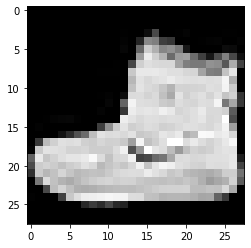

In [72]:
# La primera observacion corresponde a una bota, tal y como se interpreta de la matriz de Ys
fig, ax = plt.subplots()
tmpX = np.array(X_train[0])
tmpX = tmpX.reshape(28,28)  # ya que las observaciones estan flattened
ax.imshow(tmpX, interpolation='nearest', cmap='gray')
plt.show()

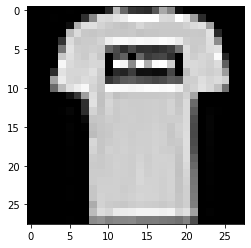

In [74]:
# La segunda observacion corresponde a la clase 0, es decir, a una tshirt, tal y como se interpreta de la matriz de Ys
fig, ax = plt.subplots()
tmpX = np.array(X_train[1])
tmpX = tmpX.reshape(28,28)  # ya que las observaciones estan flattened
ax.imshow(tmpX, interpolation='nearest', cmap='gray')
plt.show()

# Algoritmos a utilizar para Feed Forward Multi-Class Classification Neural Network

In [75]:
# fx para aplanar matrices de tetas, ya que asi lo solicita optimize
flattenize_tetas = lambda tetas_matrixes : np.concatenate(
    [
        tetas_matrixes[i].flatten()
        for i in range(len(tetas_matrixes))
    ]
)

In [153]:
def build_tetas_matrix(flat_tetas_array, nn_arch):
    """ Transformo un arreglo unidimensional de tetas, en un arreglo de matrices de tetas.
    
    flat_tetas_array: array unidimensional con los valores de tetas.
    nn_arch: Architectura de la red neuronal, es un arreglo con la cantidad de neuronas en cada capa.
    
    Retorno un arreglo de matrices de tetas con sus correspondientes shapes.
    """
    layers = len(nn_arch)
    
    # construyo los shapes utilizando la arquitectura de la Red Neuronal.
    # Shape = (Cantidad neuronas de salida, Cantidad neuronas entrada + 1) por el bias 
    shapes = [
        (
            nn_arch[i+1], # neuronas de salida en la sig. capa
            nn_arch[i]+1 # neuronas de entrada mas neurona del bias
        ) for i in range(layers - 1)
    ]
    
    # Calculo el espacio en indices que cada matriz ocupa en el arreglo
    block_size = [
        np.product(shape)
        for shape in shapes
    ]
    
    accum_block_size = np.zeros(layers, dtype=int) # indices para cada particion del flat array
    
    for i in range(len(block_size)):
        accum_block_size[i+1] = accum_block_size[i] + block_size[i] # Calculo la suma acumulada de los indices
    
    return [
        flat_tetas_array[
            accum_block_size[i] : accum_block_size[i+1]
        ].reshape(*shapes[i]) # reshapeo cada segmento del flat array a su shape correspondiente
        for i in range(len(shapes))
    ]
    

In [78]:
# Funcion para agregar la fila de bias.
def transformar_bias(x_set, grado):
    
    unos = np.ones(x_set.shape[1]) # [1] ya que X viene en formato de filas, por lo que cada columna es una observacion.
    
    if grado == 1:
        X = np.vstack(
            (
            unos,
            x_set,
            #-x_set**2
            )
        ).T # Se transpuso la matriz para tener la columna de unos y asi calcular teta_0
    elif grado == 2:
        X = np.vstack(
            (
            unos,
            x_set,
            x_set**2
            )
        ).T
    elif grado == -2:
        X = np.vstack(
            (
            unos,
            x_set,
            -x_set**2
            )
        ).T
        
    return X

In [79]:
# funcion de activacion sigmoide
def h_teta(matriz_t, matriz_x): # esta funcion es sigmoide(h_zeta)
    zeta_teta = np.matmul(
        matriz_t,
        transformar_bias(matriz_x,1).T
    )
    #print('Zeta teta: ', zeta_teta) # si zeta >= 0; entonces clase positiva.
    #[5,4,-1] = 5 + 4x1-x2 = 0
    # x2 =  5 + 4x1
    return ((1 + np.power(np.e, -1*zeta_teta))**-1) # (n,1)


In [278]:
def jota_teta(T, nn_arch, X, Y):
    A = feed_forward(
        build_tetas_matrix(T, nn_arch),
        X
    )
    m = X.shape[1]
    #print('Prediccion ', A[-1])
    #print('Producto ', np.multiply(Y, np.log(A[-1])))
    #print('Producto 2 ', np.multiply((1-Y),np.log(1 - A[-1])))

    return -(Y.T * np.log(A[-1].T) + (1 - Y.T)*np.log(1 - A[-1].T)).sum() / m


In [341]:
-(
        np.sum(
            np.multiply(Y, np.log(A[-1])) +
            np.multiply((1-Y),np.log(1 - A[-1]))
    ) / m)

NameError: name 'Y' is not defined

In [154]:
def feed_forward(T, X):
    """ Calcula un arreglo de vectores con los valores de activación de cada capa."""
    # X no tiene que entrar con bias.
    A = [X] # a0 = z0 El vector de activacion en la capa 0 es igual al vector de entradas

    for i in range(len(T)):
        A.append(
            # h_teta es la fx de activacion; sigmoide.
            h_teta(
                T[i],
                A[i] # en h_teta le agrego el bias a la matriz de activaciones
            )
        )
    return A

In [262]:
def back_propagation(T, nn_arch, X, Y):
    """Calculo la matriz del gradiente para las tetas de cada capa de la Red Neuronal.
    
    T: Arrgelo flat de todas las tetas de la Red Neuronal.
    nn_arch: Arreglo de la cantidad de neuronas por capa, incluye capa de entrada y salida.
    
    Retorno el gradiente para cada capa
    """
    #Paso 1
    
    m = X.shape[1] # [1] porque cada columna es una observacion.
    layers = len(nn_arch)
    TETAS = build_tetas_matrix(T, nn_arch)
    
    D = [0.0 for teta in TETAS] # Gradiente para las tetas de cada capa de transicion.
    #print('Len tetas builded: ', len(TETAS))
    
    # Paso 2.2
    A = feed_forward(TETAS, X) # valores de activacion para cada neurona de cada capa
    
    # Calculo el error entre la hipotesis de la NN y los valores actuales.
    d = [*range(layers - 1), A[-1] - Y] # -1 porque no tomo en cuenta la primera capa
    
    for l in range(layers-2, -1, -1): # -2 por capa de salida ya calculada, y capa de entrada. Solo para transitions.
        #print('Shape TETAS[l][:,1:] ', TETAS[l][:, 1:].T.shape)
        #print('Shape Delta[l+1] ', D[l+1].shape)
        #print('Shape A[l] ', A[l].shape)
        #print('\n')
        
        # Paso 2.4
        d[l] = np.matmul(
            TETAS[l][:, 1:].T, # (3, 3) Excluyo la neurona del bias.
            d[l+1] # (3, m) cantidad de neuronas, m -> cantidad obs.
        ) * A[l] * (1 - A[l])
        
        # Paso 2.5 y 2.6
        D[l] += np.matmul(
            d[l+1], # diferencia capa siguiente (3,5)
            np.vstack((np.ones((1,m), float), A[l])).T # (5,4) valores de las neuronas en capa de activacion 
        )
    print('Pred capa salida ', d[layers-1].shape)
    return flattenize_tetas(np.divide(D, m)) # Paso 3, retorno la matriz de gradientes flattened
    

# Normalización de inputs de la Red Neuronal

In [115]:
# Semilla de aleatoriedad para replicar el analisis.
np.random.seed(161)

In [83]:
X_train_t.shape, Y_train_t.shape

((784, 60000), (10, 60000))

Debido a que los valores de X presentan un dominio de [0-255], las operaciones matriciales pueden aumentar la complejidad computacional en los casos donde los valores son muy grandes, por lo que se procederá a normalizar tales valores.

In [326]:
RATIO = 1 / 255

In [327]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   1,   0,   0,  13,  73,   0,   0,   1,
         4,   0,   0,   0,   0,   1,   1,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   3,   0,  36, 136, 127,  62,
        54,   0,   0,   0,   1,   3,   4,   0,   0,   3,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   0, 102, 204,
       176, 134, 144, 123,  23,   0,   0,   0,   0,  12,  10,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [328]:
X = X_train_t * RATIO
X[:,0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

# Red Neuronal

In [329]:
NN_ARCH = [
    X_train_t.shape[0], # Tendre 784 neuronas de entrada, una para cada feature.
    # Capas intermedias
    130,
    # Neuronas de salida
    Y_train_t.shape[0] # Una neurona para cada clase, en total, 10 neuronas de salida
]
print('Arquitectura NN: ', NN_ARCH)

Arquitectura NN:  [784, 130, 10]


In [330]:
NN_HIDDEN_LAYERS = len(NN_ARCH) - 2
NN_HIDDEN_LAYERS

1

In [317]:
# Cada matriz de transicion tendrá las siguientes shapes
[
    (
        NN_ARCH[i+1], # Cantidad de neuronas de salida
        NN_ARCH[i]+1 # Cantidad de neuronas de entrada, mas neurona de bias
    )
    for i in range(len(NN_ARCH)-1)
]

[(2130, 785), (10, 2131)]

In [331]:
# TETAS INICIALES
TETAS = flattenize_tetas([
    np.random.rand(
        NN_ARCH[i+1], # cantidad de neuronas en siguiente capa.
        NN_ARCH[i]+1 # cantidad de neuronas de entrada, + 1 por la neurona del bias
    ) for i in range(len(NN_ARCH)-1) # No considero la última capa, porque es la hipotesis.
])
TETAS

array([0.36500686, 0.00833212, 0.66754382, ..., 0.70897968, 0.95737579,
       0.26647937])

In [332]:
back_propagation(TETAS, NN_ARCH,X, Y_train_t)

Pred capa salida  (10, 60000)


array([4.58212356e-08, 0.00000000e+00, 4.06940716e-17, ...,
       8.99999979e-01, 8.99999993e-01, 8.99999976e-01])

In [283]:
(np.array([[0,0,0,0,1,0],
          [0,0,0,0,1,0]]
        ) * np.array(
    [[0,0,0,0,1,0],
     [1,0,0,0,0,0]])).sum()

1

In [285]:
(np.array([[0,0,0,0,1,0],
          [0,0,0,0,1,0]]
        ) == np.array(
    [[0,0,0,0,1,0],
     [1,0,0,0,0,0]]))* 1

array([[1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0, 1]])

In [333]:
start = time.time()
res = op.minimize(
    fun=jota_teta,
    x0=TETAS,
    args=(NN_ARCH, X, Y_train_t),
    method='L-BFGS-B',
    jac=back_propagation,
    options={'disp': True, 'maxiter': 1300})
end = time.time()
end - start

d:\geord\docs\2020\elements\repo elements-ml\regresion_logistica\venv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
d:\geord\docs\2020\elements\repo elements-ml\regresion_logistica\venv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)
Pred capa salida  (10, 60000)


94.34400486946106

In [334]:
# Con 130 neuronas en la capa intermedia
res

      fun: 3.2508297362261156
 hess_inv: <103360x103360 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.42515374e-09, 0.00000000e+00, 8.72121884e-19, ...,
       7.06170289e-07, 7.07616028e-07, 7.05943104e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 24
      nit: 13
   status: 0
  success: True
        x: array([ 0.36500682,  0.00833212,  0.66754382, ...,  0.16937952,
        0.41777562, -0.27312078])

In [322]:
# con mas neuronas (2130)
res

      fun: 3.2508297339282053
 hess_inv: <1693360x1693360 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.48957602e-15,  0.00000000e+00,  0.00000000e+00, ...,
       -6.23304309e-08, -6.23304225e-08, -6.23304218e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 44
      nit: 22
   status: 0
  success: True
        x: array([ 0.00865902,  0.31517236,  0.6917445 , ..., -0.40390914,
        0.14517065, -0.33449626])

In [256]:
end-start

98.55805110931396

In [281]:
res.x.shape # tetas flattened

(103360,)

# Predicción

In [335]:
# Costo
jota_teta(res.x, NN_ARCH, X, Y_train_t)

3.2508297362261156

In [336]:
predicted = feed_forward(build_tetas_matrix(res.x, NN_ARCH), X)[-1]

In [340]:
((predicted > .5)*1).sum() # no predice bien

0

Intenté identificar la razón por la que la red neuronal no predice bien, sin embargo, no me fue posible hacerlo.